In [1]:
import pandas as pd
import os

In [2]:
# items
all_files = os.listdir('ngwl-predict-customer-churn')

In [3]:
items = pd.DataFrame({})
for i in [x for x in all_files if 'line' in x]:
    for fname in os.listdir('ngwl-predict-customer-churn/'+i):
        tmp = pd.read_csv(f'ngwl-predict-customer-churn/{i}/{fname}')
        tmp = tmp.groupby(by='shipment_id', as_index=False).agg({
                    'price': ['sum', 'std'], 
                    'item_id': ['nunique'],
                    'quantity': ['sum'],
                    'replaced': ['sum'],
                    'cancelled': ['sum'],
                    'discount': ['sum']
                })
        tmp.columns = tmp.columns = [x[0]+'_'+x[1]  for x in tmp.columns]
        items = pd.concat([items, tmp])

In [4]:
items = items.rename({'shipment_id_': 'shipment_id'}, axis=1)

In [5]:
# shipments
shipments = pd.DataFrame({})
for i in ['shipments2020-01-01', 'shipments2020-03-01', 'shipments2020-04-30', 'shipments2020-06-29']:
    tmp = pd.read_csv(f'ngwl-predict-customer-churn/shipments/{i}.csv')
    shipments = pd.concat([tmp, shipments])

In [6]:
adress = pd.read_csv('ngwl-predict-customer-churn/misc/addresses.csv')
# add users phone
shipments = shipments.merge(adress, how='left', left_on='ship_address_id', right_on='id')

In [8]:
shipments = shipments.merge(items, on='shipment_id', how='left')

In [10]:
# month
shipments['dt_'] = pd.to_datetime(shipments['order_completed_at'], format='%Y-%m-%d %H:%M:%S')
shipments = shipments[shipments['dt_']>='2020-01-01']
shipments['month'] = pd.to_datetime(shipments['order_completed_at'], format='%Y-%m-%d %H:%M:%S').dt.month
shipments = shipments.drop_duplicates()
shipments_first = shipments.groupby(by='phone_id', as_index=False)['dt_'].min()
shipments_first['first_month'] = shipments_first['dt_'].dt.month

In [80]:
shipments.columns

Index(['user_id', 'ship_address_id', 'shipment_id', 'order_id',
       'order_created_at', 'order_completed_at', 'shipment_starts_at',
       'retailer', 's.order_state', 'shipment_state', 's.city_name',
       's.store_id', 'total_cost', 'rate', 'dw_kind', 'promo_total',
       'total_weight', 'platform', 'os', 'shipped_at', 'id', 'phone_id',
       'price_sum', 'price_std', 'item_id_nunique', 'quantity_sum',
       'replaced_sum', 'cancelled_sum', 'discount_sum', 'dt_', 'month'],
      dtype='object')

In [12]:
f_shipments = shipments.groupby(by=['phone_id', 'month'], as_index=False).agg({
    'order_id': ['nunique'],
    'total_cost': ['sum', 'min', 'max', 'mean'],
    'rate': ['mean'],
    'promo_total': ['sum', 'mean'],
    'total_weight': ['sum', 'mean'],
    'discount_sum': ['sum'],
    'cancelled_sum': ['sum'],
    'replaced_sum': ['sum'],
    'quantity_sum': ['sum'],
    'item_id_nunique': ['sum'],
    'price_sum': ['sum', 'std'],
    'price_std': ['mean']

})

In [13]:
f_shipments.columns = [x[0]+'_'+x[1] if 
                       (x[0]!='phone_id') and 
                       (x[0]!='month')
                       else x[0] for x in f_shipments.columns]

In [14]:
f_shipments.head()

,phone_id,month,order_id_nunique,total_cost_sum,total_cost_min,total_cost_max,total_cost_mean,rate_mean,promo_total_sum,promo_total_mean,total_weight_sum,total_weight_mean,discount_sum_sum,cancelled_sum_sum,replaced_sum_sum,quantity_sum_sum,item_id_nunique_sum,price_sum_sum,price_sum_std,price_std_mean
0,2,1,1,98.0,98.0,98.0,98.0,0.0,0.0,0.0,22024,22024.0,1483.779999,1.0,0.0,38.0,29.0,3827.990007,NaN,139.825447
1,2,2,2,366.0,158.0,208.0,183.0,0.0,0.0,0.0,67946,33973.0,1284.839994,1.0,2.0,88.0,64.0,5524.700024,198.074751,89.027090
2,2,3,1,233.0,233.0,233.0,233.0,0.0,0.0,0.0,34195,34195.0,1077.389990,0.0,2.0,52.0,45.0,4716.760031,NaN,100.487544
3,2,5,1,248.0,248.0,248.0,248.0,0.0,0.0,0.0,40777,40777.0,825.089998,3.0,5.0,54.0,47.0,5684.450022,NaN,140.872190
4,3,3,2,0.0,0.0,0.0,0.0,5.0,0.0,0.0,31265,15632.5,3736.220008,5.0,1.0,152.0,84.0,6324.900032,1861.967721,94.223764


In [15]:
f_shipments = f_shipments.merge(shipments_first, on='phone_id', how='left')

In [16]:
f_shipments['month_after_first'] = f_shipments['month'] - f_shipments['first_month'] 

In [17]:
f_shipments.month_after_first.fillna(0, inplace=True)

In [18]:
f_shipments = f_shipments.drop(['first_month', 'dt_'], axis=1)

In [19]:
f_shipments['cancelled_pr'] = f_shipments['cancelled_sum_sum']/f_shipments['quantity_sum_sum']

In [20]:
f_shipments['replaced_pr'] = f_shipments['replaced_sum_sum']/f_shipments['quantity_sum_sum']

In [21]:
f_shipments = f_shipments.drop(['cancelled_sum_sum', 'replaced_sum_sum'], axis=1)

In [22]:
f_shipments.columns = [x.replace('_sum_sum', '_sum') if '_sum_sum' in x else x for x in f_shipments.columns ]

In [23]:
f_shipments = f_shipments.drop(['price_sum_std'], axis=1)

In [24]:
f_shipments.to_csv('f_shipments.csv', index=False)

In [25]:
f_shipments[['phone_id', 'month', 'discount_sum', 'quantity_sum',
       'item_id_nunique_sum', 'price_sum', 'price_std_mean',
       'cancelled_pr', 'replaced_pr']].to_pickle('f_shipments_items.pkl')

# .to_csv('f_shipments_items.csv', index=False)

In [26]:
f_shipments.columns

Index(['phone_id', 'month', 'order_id_nunique', 'total_cost_sum',
       'total_cost_min', 'total_cost_max', 'total_cost_mean', 'rate_mean',
       'promo_total_sum', 'promo_total_mean', 'total_weight_sum',
       'total_weight_mean', 'discount_sum', 'quantity_sum',
       'item_id_nunique_sum', 'price_sum', 'price_std_mean',
       'month_after_first', 'cancelled_pr', 'replaced_pr'],
      dtype='object')

In [27]:
# days count after last activity
# activity fric

In [28]:
days_cnt = shipments.groupby(by=['month', 'phone_id'], as_index=False)['dt_'].max()

In [66]:
days_cnt['day_after_last'] = 0
for i in days_cnt.index:
    days_cnt.at[i, 'day_after_last'] = (days_cnt.at[i, 'dt_'].\
                                        replace(day=1).\
                                        replace(month=days_cnt.at[i, 'month']+1)
                                       - days_cnt.at[i, 'dt_']
                                       ).days

In [76]:
days_cnt.head()

,month,phone_id,dt_,day_after_last
0,1,2,2020-01-22 10:28:37,10
1,1,6,2020-01-18 08:28:25,14
2,1,9,2020-01-03 09:05:59,29
3,1,11,2020-01-25 15:55:05,7
4,1,16,2020-01-25 11:58:56,7


In [ ]:
import datetime as dt

In [68]:
df = pd.read_pickle("fea/fea_all_actual_21_50.pkl")

In [75]:
df = df.merge(days_cnt[['month', 'phone_id', 'day_after_last']], on=['month', 'phone_id'])

In [78]:
df.columns

Index(['order_id_nunique', 'total_cost_sum', 'total_cost_min',
       'total_cost_max', 'total_cost_mean', 'total_cost_std', 'rate_mean',
       'promo_total_sum', 'promo_total_mean', 'total_weight_sum',
       'total_weight_mean', 'month', 'phone_id', 'month_after_first', 'age',
       'genger_nan', 'gender_male', 'gender_female', 'order_state_complete',
       'order_state_canceled', 'order_state_resumed', 'order_state_cart',
       'shipment_state_shipped', 'shipment_state_canceled',
       'shipment_state_collecting', 'shipment_state_ready',
       'shipment_state_shipping', 'shipment_state_ready_to_ship',
       'shipment_state_pending', 'discount_sum', 'quantity_sum',
       'item_id_nunique_sum', 'price_sum', 'price_std_mean', 'cancelled_pr',
       'replaced_pr', 'day_after_last'],
      dtype='object')

In [114]:
os_last = shipments.groupby(by=['month', 'phone_id'], as_index=False).agg({'dt_': [max], 'os': ['last']})

In [115]:
os_last.columns = os_last.columns.droplevel(1)

In [121]:
os_last['v'] = 1

In [123]:
os_last = os_last.pivot_table(
    index=['month','phone_id'], columns='os', fill_value=0, values='v', 
    aggfunc='max').reset_index()

In [124]:
os_last

os,month,phone_id,android,ios,linux,mac,other,windows
0,1,2,0,0,0,0,0,1
1,1,6,0,0,0,1,0,0
2,1,9,0,0,0,0,0,1
3,1,11,1,0,0,0,0,0
4,1,16,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
1155773,8,719367,0,1,0,0,0,0
1155774,8,719369,0,1,0,0,0,0
1155775,8,719370,1,0,0,0,0,0
1155776,8,719373,0,0,0,0,0,1


In [128]:
df = df.merge(os_last, on=['month', 'phone_id'], how='left')

In [130]:
for i in ['android', 'ios', 'linux', 'mac', 'other', 'windows']:
    df[i].fillna(0, inplace=True)

In [132]:
df.to_pickle('fea_all_actual_00_24.pkl')

In [133]:
# add city

In [150]:
city_last = shipments.groupby(by=['month', 'phone_id'],
                              as_index=False).agg({'dt_': [max], 
                                                   's.city_name': ['last']})

In [151]:
city_last

,month,phone_id,dt_,s.city_name
,,,max,last
0,1,2,2020-01-22 10:28:37,Москва
1,1,6,2020-01-18 08:28:25,Москва
2,1,9,2020-01-03 09:05:59,Москва
3,1,11,2020-01-25 15:55:05,Москва
4,1,16,2020-01-25 11:58:56,Москва
...,...,...,...,...
1155779,8,719367,2020-08-14 20:25:38,Тюмень
1155780,8,719369,2020-08-15 16:32:30,Казань
1155781,8,719370,2020-08-17 10:10:52,Санкт-Петербург


In [153]:
city_last['v'] = 1

In [152]:
city_last.columns = city_last.columns.droplevel(1)

In [155]:
import numpy as np

In [156]:
city_last['s.city_name'] = np.where(
    city_last['s.city_name'].isin(['Москва', 'Санкт-Петербург']), city_last['s.city_name'], 'Other_city')

In [157]:
city_last = city_last.pivot_table(index=['month','phone_id'],
                                  columns='s.city_name', 
                                  fill_value=0, 
                                  values='v',
                                  aggfunc='max').reset_index()

In [159]:
df = df.merge(city_last, on=['month', 'phone_id'], how='left')

In [160]:
for i in ['Other_city', 'Москва', 'Санкт-Петербург']:
    df[i].fillna(0, inplace=True)

In [161]:
df.to_pickle('fea_all_actual_00_24.pkl')

In [162]:
# communication

In [163]:
msg = pd.read_csv('ngwl-predict-customer-churn/messages/messages.csv')

In [165]:
act = pd.read_csv('ngwl-predict-customer-churn/messages/actions.csv')

In [166]:
act

,id,subject,body,type
0,239,NaN,NaN,push
1,77,NaN,NaN,push
2,213,Бесплатно доставим вам первый заказ👍,"Оформляйте скорее, доставим в удобное время!",push
3,218,👍 Новые скидки METRO в Instamart,Успей заказать продукты по выгодной цене!,push
4,221,Дарим 500 рублей за приглашенного друга!,"Обнови приложение, получи промокод и делись им...",push
...,...,...,...,...
957,2942,NaN,Скидка 500р на заказ товаров для офиса по пром...,sms
958,2925,NaN,NaN,sms
959,2927,NaN,NaN,sms
960,2928,NaN,NaN,sms


In [168]:
msg_act = msg.merge(act, left_on='action_id', right_on='id')

In [172]:
msg_act['sent'] = pd.to_datetime(msg_act['sent'], unit='s')

In [182]:
sale_msg_act = msg_act[msg_act['body'].fillna('0').str.lower().str.contains('скидка')]

In [183]:
bon_msg_act = msg_act[msg_act['body'].fillna('0').str.lower().str.contains('бонус')]

In [184]:
sale_msg_act

,sent,action_id,user_id,id,subject,body,type
1547014,2020-08-05 23:19:38,1875.0,2260800,1875,Ваш личный промокод уже внутри👉🏼 Посмотрим?,Скидка 250 рублей на третий заказ,email
1547015,2020-08-06 07:22:09,1875.0,301673,1875,Ваш личный промокод уже внутри👉🏼 Посмотрим?,Скидка 250 рублей на третий заказ,email
1547016,2020-08-05 21:10:37,1875.0,2418813,1875,Ваш личный промокод уже внутри👉🏼 Посмотрим?,Скидка 250 рублей на третий заказ,email
1547017,2020-08-05 19:31:01,1875.0,2418038,1875,Ваш личный промокод уже внутри👉🏼 Посмотрим?,Скидка 250 рублей на третий заказ,email
1547018,2020-08-06 06:36:24,1875.0,2417951,1875,Ваш личный промокод уже внутри👉🏼 Посмотрим?,Скидка 250 рублей на третий заказ,email
...,...,...,...,...,...,...,...
18275902,2020-08-12 14:18:10,2537.0,2288265,2537,NaN,Скидка 10% для вас! Используйте промокод Back1...,sms
18275903,2020-08-12 14:18:10,2537.0,2286292,2537,NaN,Скидка 10% для вас! Используйте промокод Back1...,sms
18275904,2020-08-12 14:18:10,2537.0,2284147,2537,NaN,Скидка 10% для вас! Используйте промокод Back1...,sms
18275905,2020-08-12 14:18:10,2537.0,2284215,2537,NaN,Скидка 10% для вас! Используйте промокод Back1...,sms


In [185]:
msg_act['discount_msg'] = np.where(msg_act['action_id'].isin(sale_msg_act['action_id']), 1, 0)

In [186]:
msg_act['bonus_msg'] = np.where(msg_act['action_id'].isin(bon_msg_act['action_id']), 1, 0)

In [192]:
msg_act['spam_msg'] = np.where(((msg_act['discount_msg']!=1) & (msg_act['bonus_msg']!=1)), 1, 0)

In [197]:
msg_act['v'] = 1

In [200]:
msg_act_type = msg_act.pivot_table(index=['sent','user_id'],
                                  columns='type', 
                                  fill_value=0, 
                                  values='v',
                                  aggfunc='max').reset_index()

In [204]:
msg_act_type.head()

type,sent,user_id,email,push,sms
0,2020-01-01 00:00:19,189905,1,0,0
1,2020-01-01 00:08:30,693122,1,0,0
2,2020-01-01 00:11:40,396595,1,0,0
3,2020-01-01 00:11:45,285185,1,0,0
4,2020-01-01 00:13:30,345665,1,0,0


In [203]:
msg_act = msg_act.merge(msg_act_type, on=['sent', 'user_id'])

In [207]:
msg_act['month'] = msg_act['sent'].dt.month

In [210]:
msg_act = msg_act.merge(shipments[['user_id', 'phone_id', 'month']].drop_duplicates())

In [213]:
msg_act = msg_act.groupby(by=['month', 'phone_id'], as_index=False).agg({
    'discount_msg': [sum],
    'bonus_msg': [sum],
    'spam_msg': [sum],
    'email': [sum],
    'push':[sum],
    'sms':[sum],
    'action_id': ['nunique']

})

In [217]:
# msg_act.columns = 
msg_act.columns = [x[0]+'_'+x[1] if ((x[0]!='month') and (x[0]!='phone_id')) else x[0]  for x in msg_act.columns ]

In [220]:
df = df.merge(msg_act, on=['month', 'phone_id'], how='left')

In [222]:
for i in ['discount_msg_sum',
          'bonus_msg_sum',
          'spam_msg_sum',
          'email_sum',
          'push_sum',
          'sms_sum',
          'action_id_nunique']:
    df[i].fillna(0, inplace=True)

In [224]:
df.to_pickle('fea_all_actual_01_29.pkl')

In [225]:
# empty month ago

In [229]:
mnth_orders = df[['order_id_nunique', 'month', 'phone_id']]

In [232]:
mnth_before = mnth_orders[['month', 'phone_id']]

In [233]:
mnth_before['month'] = mnth_before['month']-1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [236]:
mnth_before = mnth_before.merge(mnth_orders, on=['month', 'phone_id'], how='left')

In [238]:
mnth_before['month'] = mnth_before['month']+1

In [240]:
mnth_before['gap_in_month_before'] = np.where(mnth_before['order_id_nunique']>0, 0, 1)

In [244]:
df = df.merge(mnth_before[['month', 'phone_id', 'gap_in_month_before']], on=['month', 'phone_id'])

In [245]:
df.to_pickle('fea_all_actual_01_38.pkl')

In [246]:
# frequancy_items

In [ ]:
# items = pd.DataFrame({})
# for i in [x for x in all_files if 'line' in x]:
#     for fname in os.listdir('ngwl-predict-customer-churn/'+i):
#         tmp = pd.read_csv(f'ngwl-predict-customer-churn/{i}/{fname}')
#         tmp = tmp.groupby(by='item_id', as_index=False).agg({
#                     'quantity': ['sum']
#                 })
#         tmp.columns = tmp.columns = [x[0]+'_'+x[1]  for x in tmp.columns]
#         items = pd.concat([items, tmp])

In [247]:
# % возвращенных после коммуникации

In [248]:
msg = pd.read_csv('ngwl-predict-customer-churn/messages/messages.csv')
act = pd.read_csv('ngwl-predict-customer-churn/messages/actions.csv')
msg_act = msg.merge(act, left_on='action_id', right_on='id')
msg_act['sent'] = pd.to_datetime(msg_act['sent'], unit='s')
sale_msg_act = msg_act[msg_act['body'].fillna('0').str.lower().str.contains('скидка')]
bon_msg_act = msg_act[msg_act['body'].fillna('0').str.lower().str.contains('бонус')]
msg_act['discount_msg'] = np.where(msg_act['action_id'].isin(sale_msg_act['action_id']), 1, 0)
msg_act['bonus_msg'] = np.where(msg_act['action_id'].isin(bon_msg_act['action_id']), 1, 0)
msg_act['spam_msg'] = np.where(((msg_act['discount_msg']!=1) & (msg_act['bonus_msg']!=1)), 1, 0)

In [251]:
shipments_order_part = shipments[['user_id', 'dt_', 'phone_id', 's.order_state', 'shipment_state']].drop_duplicates()

In [309]:
shipments_and_msg = shipments_order_part.merge(msg_act[[
    'sent', 
    'user_id',
    'type', 
    'discount_msg', 
    'bonus_msg', 
    'spam_msg'
]],
 on='user_id')

In [310]:
shipments_and_msg['diff'] = shipments_and_msg['dt_']-shipments_and_msg['sent']

In [311]:
shipments_and_msg['diff_days'] = shipments_and_msg['diff'].dt.days

In [312]:
shipments_and_msg = shipments_and_msg[shipments_and_msg.diff_days>=0]

In [313]:
shipments_and_msg_days_diff = shipments_and_msg.groupby(by='phone_id', as_index=False)['diff_days'].min()

In [314]:
shipments_and_msg_days_diff.drop_duplicates(inplace=True)

In [315]:
shipments_and_msg_days_diff.describe()

,phone_id,diff_days
count,505503.000000,505503.000000
mean,313835.624564,2.200193
std,203937.205929,11.171409
min,2.000000,0.000000
25%,140366.500000,0.000000
50%,289138.000000,0.000000
75%,476971.500000,0.000000
max,719374.000000,239.000000


In [316]:
import seaborn as sns

In [317]:
%matplotlib inline
import matplotlib.pyplot as plt

In [318]:
cnt_phone = shipments_and_msg_days_diff.groupby(by='diff_days', as_index=False)['phone_id'].count()

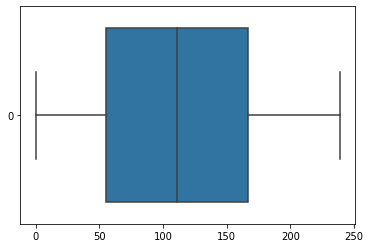

In [319]:
sns.boxplot(data=cnt_phone['diff_days'], orient='h');

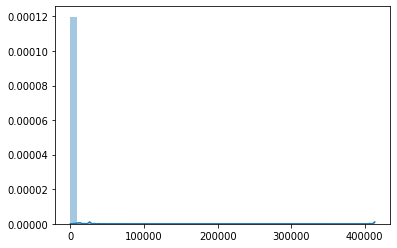

In [320]:
sns.distplot(cnt_phone)

In [321]:
cnt_phone[cnt_phone['diff_days']<=3]

,diff_days,phone_id
0,0,413614
1,1,25811
2,2,13847
3,3,8468


In [326]:
retur_users = shipments_and_msg[shipments_and_msg['s.order_state']=='complete']

In [330]:
retur_users = retur_users.merge(retur_users.groupby(by=['phone_id', 'sent'], as_index=False)['diff_days'].min())

In [334]:
retur_users['month'] = retur_users['dt_'].dt.month

In [343]:
shipments['rnk'] = shipments.groupby(by='phone_id')['dt_'].rank(method='first')

In [346]:
shipments['rnk2'] = shipments['rnk']-1

In [350]:
shipments_lag = shipments.merge(shipments[['rnk2', 'phone_id', 'dt_']], left_on=['rnk', 'phone_id'], right_on=['rnk2', 'phone_id'])

In [353]:
shipments_lag['days_lag'] = (shipments_lag['dt__y']-shipments_lag['dt__x']).dt.days

In [356]:
shipments_lag_30 = shipments_lag[shipments_lag['days_lag']>=30]

In [358]:
shipments_lag_30.groupby(by='month', as_index=False).agg({'phone_id':['nunique']})

,month,phone_id
,,nunique
0,1,12546
1,2,14601
2,3,24700
3,4,24533
4,5,35912
5,6,36869
6,7,20489
7,8,20


In [366]:
shipments_lag_30_m = shipments_lag_30.merge(retur_users[['dt_', 'phone_id']], on=['phone_id'])
shipments_lag_30_m = shipments_lag_30_m[shipments_lag_30_m.dt_>shipments_lag_30_m.dt__y]

In [368]:
shipments_lag_30_m.groupby(by='month', as_index=False).agg({'phone_id':['nunique']})

,month,phone_id
,,nunique
0,1,8124
1,2,9197
2,3,15318
3,4,12669
4,5,15577
5,6,14253
6,7,3963


In [382]:
with_comm = df[
    (df.gap_in_month_before==0)
   &
   (df.action_id_nunique==1)
  ].groupby(by='month', as_index=False).agg({'phone_id':['nunique']})

In [383]:
with_comm

,month,phone_id
,,nunique
0,2,1405
1,3,1034
2,4,2395
3,5,3985
4,6,6017
5,7,3401
6,8,1801
